# Stimuli using Bézier Curves

In [1]:
%matplotlib inline

import sys
import os

# Add parent directory (where pygestalt lives) to sys.path
sys.path.append(os.path.abspath(".."))

from pathlib import Path

import numpy as np
import scipy
from scipy.spatial import cKDTree

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import *

import pygestalt as gs
from pygestalt import sampler

import skimage as ski

In [2]:
outdir = Path(os.getcwd()) / 'outputs'
os.makedirs(outdir, exist_ok=True)

## Construction of a Bézier curve

We construct a Bézier curve by specifying a sequence of control points, with the first and the last one corresponding to the starting and the ending position of the curve.

#### A random Bezier curve

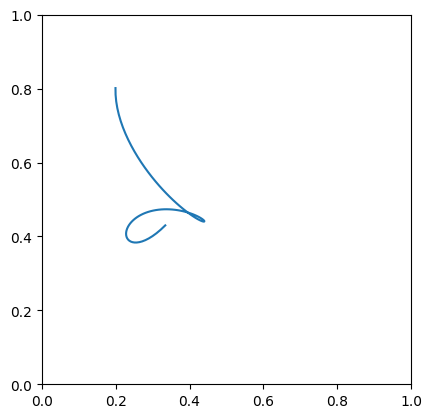

In [3]:
Ps = np.random.uniform(size=(6,2))
# Ps = np.vstack([[0.2,0], Ps, [0.8,1]])
bx, by = gs.sampler.bezier_curve_position(np.linspace(0,1,100),Ps).T

plt.plot(bx,by)
ax = plt.gca()
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect('equal')

### A fixed Bezier curve

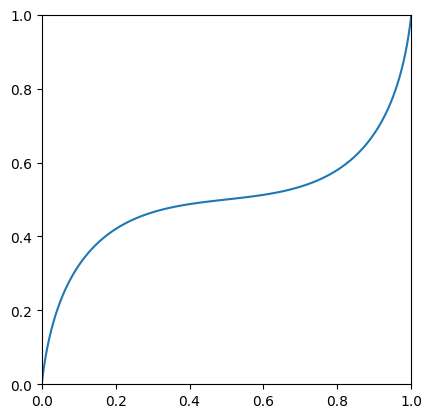

In [4]:
# Ps = np.random.uniform(size=(4,2))
# Ps = np.vstack([[0.2,0], Ps, [0.8,1]])

Ps = np.array([[0.,0.], [0.1,0.9], [0.9,0.1], [1.,1.]])
#Ps = np.array([[0.,0.], [1.,1.]])
bx, by = gs.sampler.bezier_curve_position(np.linspace(0,1,100),Ps).T

plt.plot(bx,by)
ax = plt.gca()
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect('equal')

## Generate random stimuli using Bezier curves

In [5]:
radius = 0.02
thresh = 1e-3

%time C, H = sampler.draw_positions(radius, sampler.bezier_curve(Ps), thresh=thresh)
%time D, _ = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 4.66 s, sys: 107 ms, total: 4.77 s
Wall time: 7.45 s
CPU times: user 16.9 s, sys: 114 ms, total: 17.1 s
Wall time: 17.1 s


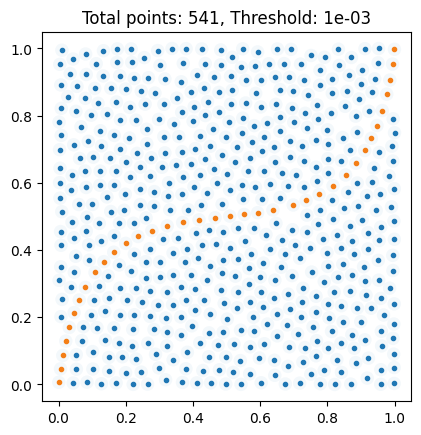

In [6]:
fig, ax = gs.utils.ball_plot(D, C, radius=radius, thresh=thresh)

### Perfectly aligned segments

In [7]:
# Define the patch function

l=0.025
w=0.005
pfunc = lambda z,h: gs.patch.segment(z, h, l, w)

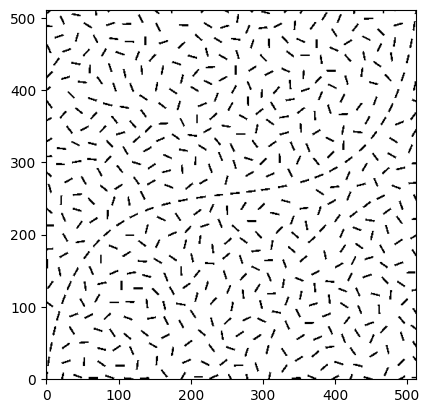

In [8]:
N = 512
If, Tf = gs.patch.generate_image(C, H, N=N, pfunc=pfunc)
Ig, Tg = gs.patch.generate_image(D, N=N, pfunc=pfunc)

I = If + Ig

Im = I.copy()
# Im = np.fliplr(np.rot90(Im,-1))

plt.imshow(Im, aspect='equal', origin='lower', cmap='binary')
# plt.set_cmap('binary')

### Add jitters

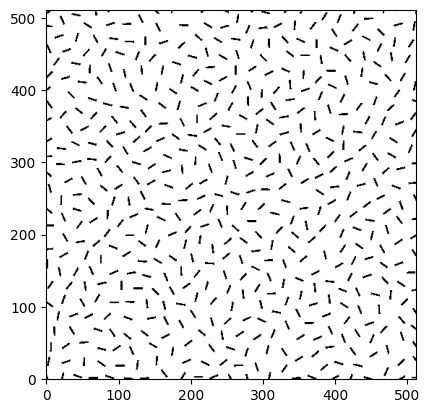

In [9]:
# H1 = H + np.random.randn(*H.shape) * 0.25
H1 = gs.utils.add_jitter(H[:,0], H[:,1], 30).T

If, _ = gs.patch.generate_image(C, H1, N=N, pfunc=pfunc)

I = If + Ig

Im = I.copy()
# Im = np.fliplr(np.rot90(Im,-1))

plt.imshow(Im, aspect='equal', origin='lower', cmap='binary')
# plt.set_cmap('binary')

### Same generation but with Gabor patches

In [10]:
f = 100
σ2 = 0.002
pfunc = lambda z,h: gs.patch.gabor(z, h, f, σ2)

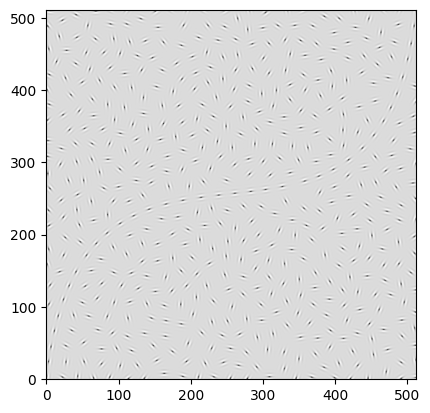

In [11]:
N = 512
If,_ = gs.patch.generate_image(C, H, N=N, pfunc=pfunc)
Ig,_ = gs.patch.generate_image(D, N=N, pfunc=pfunc)
I = If + Ig

plt.imshow(I, aspect='equal', origin='lower', cmap='Greys')

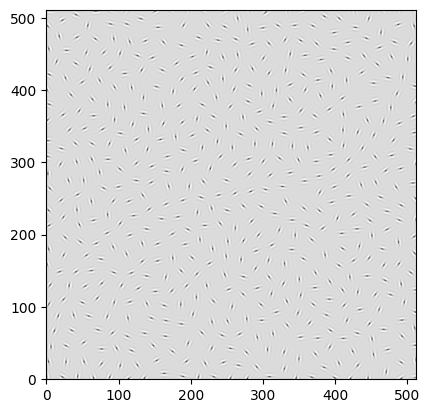

In [12]:
# H1 = H + np.random.randn(*H.shape) * 0.25
H1 = gs.utils.add_jitter(H[:,0], H[:,1], 30).T

If, _= gs.patch.generate_image(C, H1, N=N, pfunc=pfunc)
I = If + Ig

plt.imshow(I, aspect='equal', origin='lower', cmap='Greys')


In [13]:
def closest_neighbours(points, tangents, i):
    """
    Find the nearest neighbouring points and their tangents for a given point.

    Parameters
    points : (n, d) ndarray
        Array of n points in d-dimensional space.
    tangents : (n, d) ndarray
        Array of tangent vectors corresponding to each point.
    i : int
        Index of the reference point.

    Returns
    spoint : (d,) ndarray 
        The reference point at index `i`.
    norm_stang : (d,) ndarray
        Normalized tangent vector of the reference point.
    closest_points : (k-1, d) ndarray
        Coordinates of the k-1 nearest neighbours (excluding the point itself).
    norm_tang : (k-1, d) ndarray
        Normalized tangent vectors of the neighbouring points.
    """
    tree = cKDTree(points)
    # Reference point and normalized tangent
    spoint = points[i]
    norm_stang = tangents[i] / np.linalg.norm(tangents[i])

    # Query 7 neighbors, drop the point itself
    dists, idxs = tree.query(spoint, k= 11)
    dists, idxs = dists[1:], idxs[1:]

    # Select neighbors
    closest_points = points[idxs]
    closest_tang   = tangents[idxs]

    # Normalize tangents as a 2D array
    norm_tang = closest_tang / np.linalg.norm(closest_tang, axis=1, keepdims=True) 

    # Dot products as a clean NumPy array
    #dots = norm_tang @ stang_norm

    return spoint, norm_stang, closest_points, norm_tang

In [14]:
def problem_score(points, ref_point, tangents, ref_tangent):
    # Vector between two sets of points
    shift = points - ref_point   # shape (n, d)

    # Normalize the vectors (row-wise)
    norms = np.linalg.norm(shift, axis=1, keepdims=True)  # shape (n, 1)
    norm_shift = shift / np.where(norms == 0, 1, norms)            # avoid division by zero

    # Compute dot products
    sdot = norm_shift @ ref_tangent                        # (n,) assuming stang is shape (d,)
    cdot = np.einsum("ij,ij->i", norm_shift, tangents)   # (n,) assuming tang is shape (n, d)

    # Similarity measure
    sim = np.abs(sdot * cdot)

    dist_cor = 10 / (9 + np.exp(5 * ((norms / 0.05)-1)))
    dist_cor = dist_cor.ravel()
    problem_score = sim * dist_cor
    
    result = [ref_point, ref_tangent, points, problem_score]
    result_lists = [arr.tolist() for arr in result]
    
    return result_lists


In [15]:
points = D       # coordinates (N, 2)
tangents = Tg      # tangent vectors (N, 2)

#points = np.array([[0.5, 0.5], [0.25, 0.25], [0.75, 0.25], [0.20, 0.5], [0.80, 0.5], [0.25, 0.75], [0.75, 0.75]])
#tangents = np.array([[2, 0], [(-1), (-1)], [(-1), 1], [(-1), 0], [1,1], [0,1], [1, 0]])



In [16]:
ratings = []
problems = []
for i in range(len(points)):
    r, rt, p, pt = closest_neighbours(points, tangents, i)
    rating = problem_score(p, r, pt, rt)
    ratings.append(rating)
    for ps in rating[3]:
        if ps > 0.9:
            problems.append(i)

for i in problems:
    tangents[i][0] = tangents[i][0] + np.random.uniform(-0.5, 0.5)
    tangents[i][1] = tangents[i][1] + np.random.uniform(-0.5, 0.5)


# EOF